# Experiment 1.5.2
Experiment 1.5.1, but with ResNet18 instead of ResNet50.

The model is switched and the discussion in section 6 is different. Otherwise, this notebook is just a duplicate of 1.5.1.

This is a bit of a step back from experiment 1.4 in terms of complexity. We are back to a single dot and back to dealing with the final layer. The difference now is we will vary the dot size and position.

In [1]:
import os
import pickle
import time
import copy
import pathlib
import itertools
from collections import namedtuple
from enum import Enum
from typing import *
import IPython
import cv2
import numpy as np
import torch.optim
import torch.hub
import torchvision as tv
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
from icecream import ic
import nncolor as nc
import nncolor.data

In [2]:
presentation_mode = True
if presentation_mode:
    import warnings
    plt.style.use('science')
    warnings.filterwarnings('ignore')
    mpl.rcParams.update({'font.size': 30})
    mpl.rcParams.update({'axes.labelsize': 30})
    mpl.rcParams.update({'text.usetex': True})

In [3]:
def imshow(img):
    """Show image. 
    
    Image is a HWC numpy array with values in the range 0-1."""
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # cv2 imencode takes images in HWC dimension order.
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i) 

## 1. Notebook constants
Variables used as constants throughout the notebook.

In [4]:
EXPERIMENT = '1_5_2'
# Choose CPU or GPU.
device = torch.device('cuda:1')
#device = "cpu"

# Choose small or large (standard) model variant
model_name = 'resnet18'
def model_fctn():
    if model_name == 'resnet18':
        return tv.models.resnet18(pretrained=True)
    elif model_name == 'resnet50':
        return tv.models.resnet50(pretrained=True)
resnet_model = model_fctn()

IMG_SHAPE = (224, 224, 3)
GRID_SHAPE = (1, 1)
CENTER_ACTIVATION = 0 # position (1, 1) in grid of 1x1
NUM_CELLS = 1
cell_shape = nc.data.cell_shape(GRID_SHAPE, IMG_SHAPE)
assert np.array_equal(cell_shape, IMG_SHAPE[0:-1])
BATCH_SIZE = 64 
NUM_EPOCHS = 20
NUM_FC_CHANNELS = 512 if model_name == 'resnet18' else 2048
SAVE_PATH_FMT = './resources/exp_' + EXPERIMENT + '/{model_name}_radius_{radius}_offset_{offset}_save'
ACC_SAVE_PATH = './resources/exp_' + EXPERIMENT + f'/{model_name}_accuracy.json'

## 2. Dataset
We will generate 15x29=435 different dataset variations. For each variation, we will run the type of experiment from experiment 1.3.

In [5]:
# Variations by dot position, offset from center along south-east diagonal.
# 15 different offsets, from 0 to 112 inclusive.
# 112 / 8 = 14
offsets = list(range(0, 112+1, 8))
assert len(offsets) == 15
# Varations, by dot radius.
# 29 different offsets from 0 to 168 inclusive. 0 is replaced by 1 for the first radius.
# 168 / 6 = 28. 
radii = [1,] + list(range(6, 168 + 1, 6))
assert len(radii) == 29

Some examples are shown below:

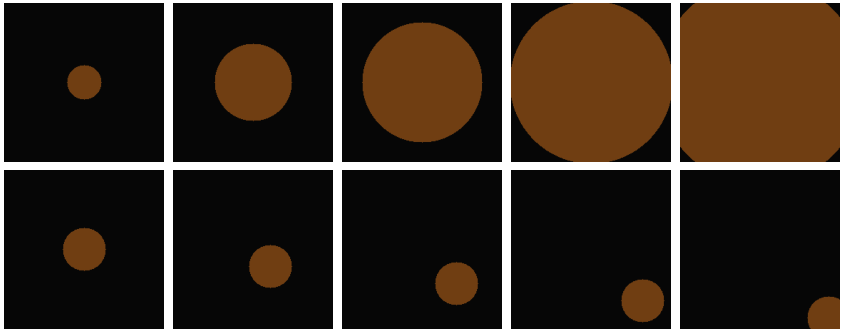

In [6]:
def show_examples():
    """Print some example dots."""
    fig = plt.figure(figsize=(15, 6))
    by_size = [nc.data.ColorDotDataset(nc.data.exp_1_1_data_filtered,
                                       grid_shape=GRID_SHAPE,
                                       dot_radius=r) for r in radii[4:-1:5]]
    by_offset = [nc.data.ColorDotDataset(nc.data.exp_1_1_data_filtered,
                                         grid_shape=GRID_SHAPE, dot_radius=30, 
                                         dot_offset=o) for o in offsets[0:-1:3]]
    # Display with Matplotlib
    cols = 5
    rows = 2
    for i in range(cols):
        ax_top = fig.add_subplot(rows, cols, i+1)
        ax_bottom = fig.add_subplot(rows, cols, i+cols+1)
        ax_top.set_axis_off()
        ax_bottom.set_axis_off()
        ax_top.imshow(by_size[i][0]['image'])
        ax_bottom.imshow(by_offset[i][0]['image'])
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.savefig("./out/report/nn_dataset_ob.pdf", format="pdf", bbox_inches="tight")
    plt.show()
show_examples()

In [7]:
# Data augmentation and normalization
normalize_transform =  tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
to_CHW_tensor_transform = tv.transforms.ToTensor()
data_transform = tv.transforms.Compose([to_CHW_tensor_transform, normalize_transform])

def datasplits_by_pos_and_radius():
    """Create the datasets."""
    color_data = nc.data.exp_1_1_combined_data
    # We are ignoring the very few data points labeled "both".
    color_data = color_data[color_data['ans'] != nc.data.LABEL_TO_COLOR_ID['both']]
    color_data = nc.data.deserialize(color_data)
    def train_test_val(offset, radius):
        train_ds, test_ds, val_ds = nc.data.train_test_val_split(color_data,
                                                                dot_radius=radius,
                                                                grid_shape=GRID_SHAPE,
                                                                dot_offset=(offset, offset))
        DataSplit = namedtuple('DataSplit', ['ds', 'loader', 'size'])
        splits = {
            'train': DataSplit(train_ds, torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=4), len(train_ds)),
            'test':  DataSplit(test_ds,  torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4), len(test_ds)),
            'val':   DataSplit(val_ds,   torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4), len(val_ds))
        }
        splits['val'].ds.transform = data_transform
        splits['train'].ds.transform = data_transform
        splits['test'].ds.transform = to_CHW_tensor_transform
        return splits
    datasplits = {(o,r): train_test_val(o, r) for (o,r) in itertools.product(offsets, radii)}
    return datasplits 
datasplits = datasplits_by_pos_and_radius()

## 3. Model
The model is a pretrained ResNet, with all parameters fixed except those in the final layer.

In [8]:
def tweaked_model():
    model = model_fctn()
    for param in model.parameters():
        param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 4)
    return model

## 4. Training

In [ ]:
def train_new_model(datasplit):
    model = tweaked_model()
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch in datasplit[phase].loader:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = torch.nn.functional.cross_entropy(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            denom = datasplit[phase].size
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects.double() / denom
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())            
    return best_model_wts

def run_training(force=False):
    for (offset, radius), datasplit in datasplits.items():
        save_path = SAVE_PATH_FMT.format(model_name=model_name,  offset=offset,  radius=radius)
        if not force and pathlib.Path(save_path).exists():
            continue
        print(f'Training start. Offset {offset}, radius {radius}')
        best_model_wts = train_new_model(datasplit)
        torch.save(best_model_wts, save_path)
run_training()

## 5. Investigate model
For all datasets, a separate model has been trained. Now test each model on the test set and record the accuracy. The results are shown below.

In [10]:
def inspect(): 
    acc = {}
    for (offset, radius), datasplit in datasplits.items():
        model = tweaked_model().to(device)
        model.load_state_dict(
            torch.load(SAVE_PATH_FMT.format(model_name=model_name, 
                                            radius=radius, offset=offset)))
        corrects = 0
        for batch in datasplit['test'].loader:
            images = batch['image']
            inputs = normalize_transform(images).to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
        acc[(offset, radius)] = corrects / datasplit['test'].size
    return acc

if pathlib.Path(ACC_SAVE_PATH).exists():
    with open(ACC_SAVE_PATH, 'rb') as f:
        acc = pickle.load(f)
else:
    acc = inspect()
    with open(ACC_SAVE_PATH, 'wb') as f:
        pickle.dump(acc, f)

Min 0.567, max: 0.862, mean: 0.818, var: 0.001



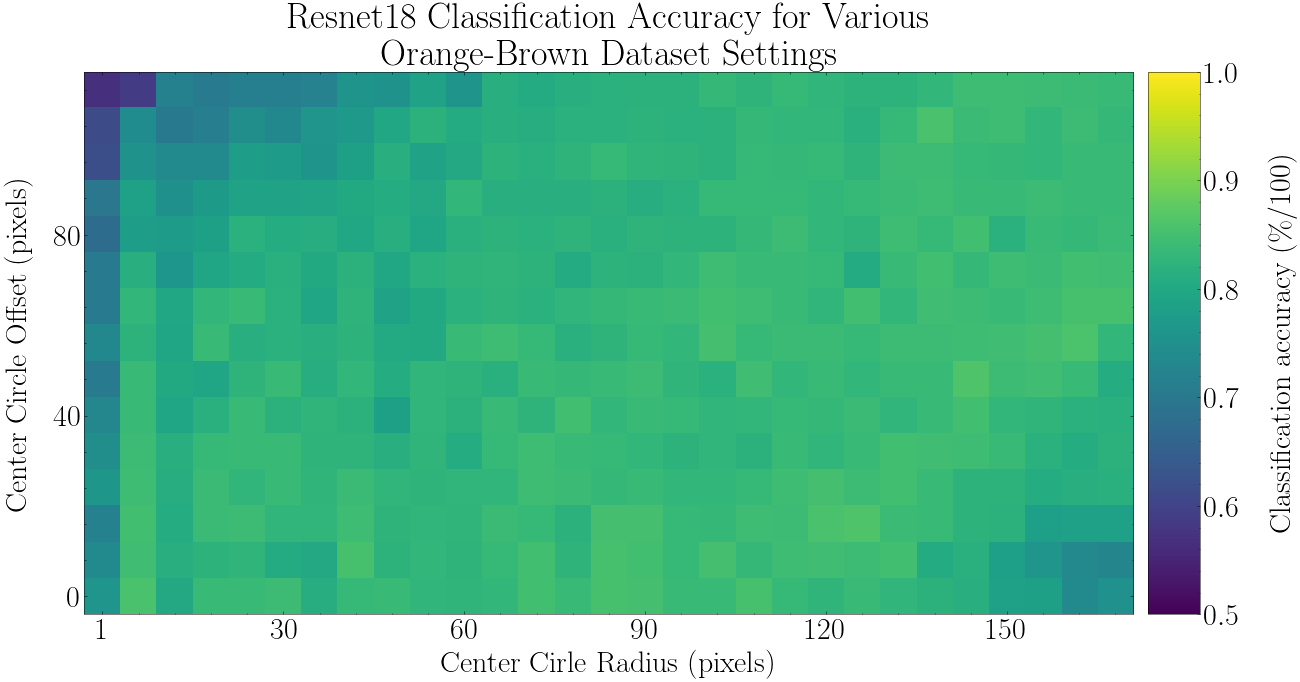

In [11]:
def display_data():
    arr = np.zeros((len(offsets), len(radii)))
    xlabels = offsets
    ylabels = radii
    for odx, o in enumerate(offsets):
        for rdx, r in enumerate(radii):
            arr[odx, rdx] = acc[(o, r)]
    fig, ax = plt.subplots(figsize=(20, 20))
    cmap = 'gray' 
    cmap = 'viridis'
    plt_img = ax.imshow(arr, cmap=cmap, vmin=0.5, vmax=1.0)
    ax.invert_yaxis()
    ax.set_xlabel('Center Cirle Radius (pixels)')
    ax.set_ylabel('Center Circle Offset (pixels)', labelpad=20)
    ax.set_title(f'{model_name.capitalize()} Classification Accuracy for Various\nOrange-Brown Dataset Settings')
    num_labels = 7
    x_positions, x_labels = zip(*((i, radii[i]) for i in range(0, len(radii), 5)))
    y_positions, y_labels = zip(*((i, offsets[i]) for i in range(0, len(offsets), 5)))
    ax.xaxis.set_ticks(x_positions)
    ax.xaxis.set_ticklabels(x_labels)
    ax.yaxis.set_ticks(y_positions)
    ax.yaxis.set_ticklabels(y_labels)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(plt_img, cax=cax)
    cax.set_ylabel('Classification accuracy (\%/100)', labelpad=28)
    print(f'Min {np.min(arr):.3f}, max: {np.max(arr):.3f}, mean: {np.mean(arr):.3f}, var: {np.var(arr):.3f}\n')
display_data()    

## 6. Discussion
81.8% mean accuracy. Similar to the ResNet50 test (81.1%). The ResNet18 network seems to have had less of an issue with small circles with large offset. I wonder if this is a consequence of the differences in depth and if the relationship extends to even deeper or shallower networks. If so, it might suggest transfer learning be carried out differently for different network depths (more layers needing to be retrained for deeper networks).